In [103]:
import numpy as np
import matplotlib.pyplot as plt

In [104]:
K = 10
TRIALS = 1000
MEAN_STDDEV = 10
SAMPLE_STDDEV = 10
MEANS = np.random.normal(0, MEAN_STDDEV, 10)
DATA = np.array([np.random.normal(mu, SAMPLE_STDDEV, 1000) for mu in MEANS])
COUNTS = [0] * K

In [105]:
print(MEANS)
print(np.mean(DATA, axis=1))

[-16.61274876  19.07171696  16.03580568   6.27311427  -9.67304706
  17.37261248  15.80972653  19.04249065  -6.6191052  -12.37765474]
[-16.66829228  18.8434228   16.54947031   6.03645123  -9.82589012
  17.38286632  15.99958928  18.64111316  -5.94529532 -12.42440064]


In [106]:
class Env:
    def __init__(self, data, step=0):
        self.data = data
        self.length = data.shape[1]
        self.step = step

class Bandit:
    def __init__(self, k, epsilon, env):
        self.k = k
        self.epsilon = epsilon
        self.env = env
        self.counts = [0 for _ in range(k)]
        self.estimates = [0 for _ in range(k)]
        self.reward = 0
        self.avg = [0 for _ in range(env.length)]
    
    def act(self):
        x = np.random.random()
        if x > self.epsilon:
            index = np.argmax(self.estimates)
        else:
            index = np.random.randint(0, self.k)

        x = self.env.data[index, self.env.step]
        n = self.counts[index]
        mean = self.estimates[index]
        self.counts[index] += 1
        self.estimates[index] = (n*mean+x)/(n+1)
        self.reward += x
        if self.env.step == 0:
            self.avg[self.env.step] = x
        else:
            self.avg[self.env.step] = (self.env.step*self.avg[self.env.step-1] + x)/(self.env.step+1)
        self.env.step += 1
        
    def reset(self):
        self.counts = self.k*[0]
        self.estimates = self.k*[0]
        self.reward = 0
        self.avg = self.env.length * [0]
        self.env.step = 0
        
    def run(self):
        for i in range(self.env.length):
            self.act()
        return self.reward

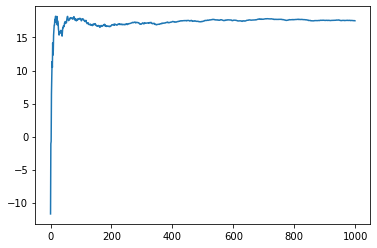

In [107]:
env = Env(DATA)
bandit = Bandit(K, 0.1, env)
bandit.run()
plt.plot(bandit.avg)
bandit.reset()